Import libraries

In [3]:
import torch
import torchvision
from torch.nn import functional as F

Get training and testing datasets and convert CIFAR10 images to grayscale.

In the data loader, we specify the batch size = 64 as required by the problem


In [4]:
Transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),torchvision.transforms.ToTensor()])

trainingdata = torchvision.datasets.CIFAR10(root='./ data', train=True, download=True, transform=Transform) 
testdata = torchvision.datasets.CIFAR10(root='./data',  train=False, download=True, transform=Transform)

trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./ data/cifar-10-python.tar.gz to ./ data


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Let us observe 5 images from training data in greyscale


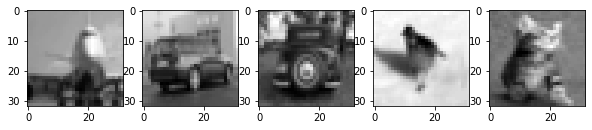

In [5]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = iter(trainDataLoader).next()

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

In the LinearReg class we define the architecture of our neural network. The first hidden layer (layer1) has 256 neurons, layer2 has 128 neurons and layer3 has 64 neurons. layer4 is the output layer that has 10 output nodes.

All the hidden layers have ReLU functions after the linear transform. The learning rate is fixed as 0.01 and SGD optimizer is used.

In [6]:
class Multi_layer_CIFAR_10_Classifier(torch.nn.Module):
  def __init__(self):
    super(Multi_layer_CIFAR_10_Classifier, self).__init__()
    self.layer1 = torch.nn.Linear(32*32, 256)
    self.layer2 = torch.nn.Linear(256, 128)
    self.layer3 = torch.nn.Linear(128, 64)
    self.layer4= torch.nn.Linear(64, 10)

  def forward(self, x):
    x = x.view(-1,32*32)

    x = self.layer1(x)
    x = torch.nn.functional.relu(x)

    x = self.layer2(x)
    x = torch.nn.functional.relu(x)

    x = self.layer3(x)
    x = torch.nn.functional.relu(x)

    x = self.layer4(x)
    
    return x

net = Multi_layer_CIFAR_10_Classifier().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

Now, that we have our architecture ready, we will forward propagation to get the average training loss, and propagate backwards the corrected weights for training data. For testing data, we shall only run forward propagation to get testing loss and accuracy. 

The whole operation is done for 100 epochs (in this case) and the training loss, testing loss and accuracy were printed for each epoch.

In [7]:
train_loss_history = []
test_loss_history = []
epoch = 50
for epoch in range(epoch):
  train_loss = 0.0
  test_loss = 0.0
  test_accuracy = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
      test_accuracy += (torch.eq(torch.max(predicted_output, 1)[1],labels).sum()).data.cpu().numpy()

  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  test_accuracy = test_accuracy/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s, Test accuracy is %s'%(epoch, train_loss, test_loss, test_accuracy))

Epoch 0, Train loss 2.2957988312787108, Test loss 2.2842178344726562, Test accuracy is 9.64968152866242
Epoch 1, Train loss 2.2425887517612, Test loss 2.1815004956190753, Test accuracy is 12.343949044585987
Epoch 2, Train loss 2.1500272292005436, Test loss 2.125740386118555, Test accuracy is 13.656050955414013
Epoch 3, Train loss 2.096910316163622, Test loss 2.0740387416948938, Test accuracy is 15.707006369426752
Epoch 4, Train loss 2.057954638510409, Test loss 2.0513210456082773, Test accuracy is 15.828025477707007
Epoch 5, Train loss 2.033283368553347, Test loss 2.026677694290307, Test accuracy is 16.777070063694268
Epoch 6, Train loss 2.0102267093060875, Test loss 2.029702494098882, Test accuracy is 16.681528662420384
Epoch 7, Train loss 1.983467761970237, Test loss 1.9668600179587201, Test accuracy is 18.605095541401273
Epoch 8, Train loss 1.955860069340757, Test loss 1.962485703693074, Test accuracy is 18.81528662420382
Epoch 9, Train loss 1.9306327836287906, Test loss 1.938729371

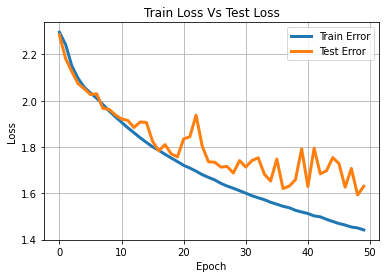

In [8]:
plt.plot(range(epoch+1),train_loss_history,'-',linewidth=3,label='Train Error')
plt.plot(range(epoch+1),test_loss_history,'-',linewidth=3,label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.title('Train Loss Vs Test Loss')
plt.legend()